# Introduction
Proteins are responsible for many activities in our tissues, organs, and bodies and they also play a central role in the structure and function of cells. Proteins are large molecules composed of 20 types of building-blocks known as amino acids. The human body makes tens of thousands of different proteins, and each protein is composed of dozens or hundreds of amino acids that are linked sequentially. This amino-acid sequence determines the 3D structure and conformational dynamics of the protein, and that, in turn, determines its biological function. Due to ongoing genome sequencing projects, we are inundated with large amounts of genomic sequence data from thousands of species, which informs us of the amino-acid sequence data of proteins for which these genes code. 
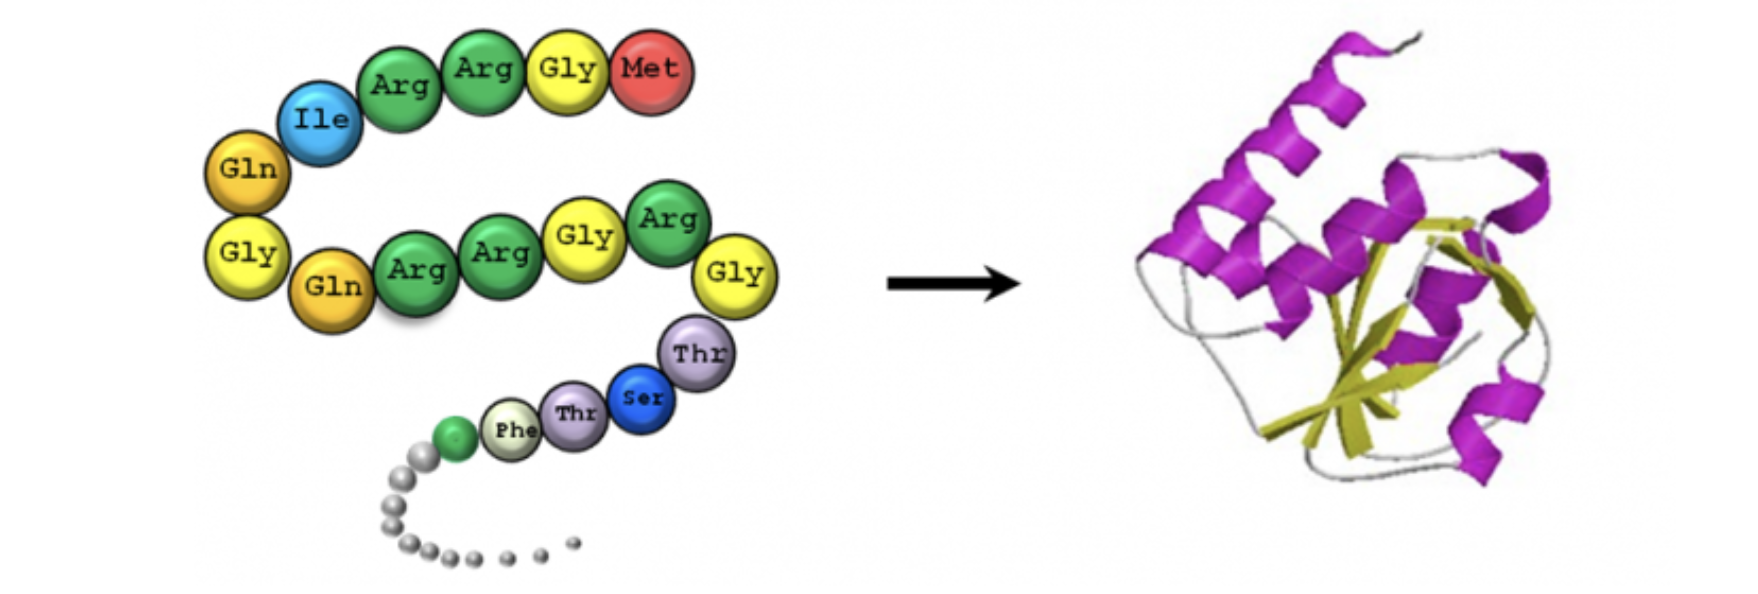

## Scope
The accurate assignment of biological function to the protein is key to understanding life at the molecular level. However, assigning function to any specific protein can be made difficult due to the multiple functions many proteins have, along with their ability to interact with multiple partners. More knowledge of the functions assigned to proteins—potentially aided by data science—could lead to curing diseases and improving human and animal health and wellness in areas as varied as medicine and agriculture.

## Project Goals
The goal of this project is to predict the function of a set of proteins. I will develop a model trained on the amino-acid sequences of the proteins and on other data, this work willl help researchers better understand the function of proteins, which is important for discovering how cells, tissues, and organs work. This may also aid in the development of new drugs and therapies for various diseases.

## Data
For the training set, I include all proteins with annotated terms that have been validated by experimental or high-throughput evidence, traceable author statement (evidence code TAS), or inferred by curator (IC). I use annotations from the UniProtKB release of 2022-11-17.

## Analysis
This solution will use descriptive statistics and data visualization to find key figures in understanding the distribution, count, and relationship between variables. Since the goal of the project to make predictions on the function of a set of proteins, classification algorithms from the supervised learning family of machine learning models will be implemented, including Neural Networks and Deep Reinforcement Learning, as well as Natural Language Processing to classify by description.


## Evaluation
The maximum F-measure based on the weighted precision and recall will be calculated on each of the three test sets and the final performance measure will be an arithmetic mean of the three maximum F-measures (for MF (Molecular Function), BP, and CC). The formulas for computing weighted F-measures are as follows:

Precision (pr), recall (rc), and the resulting Fmax are defined as

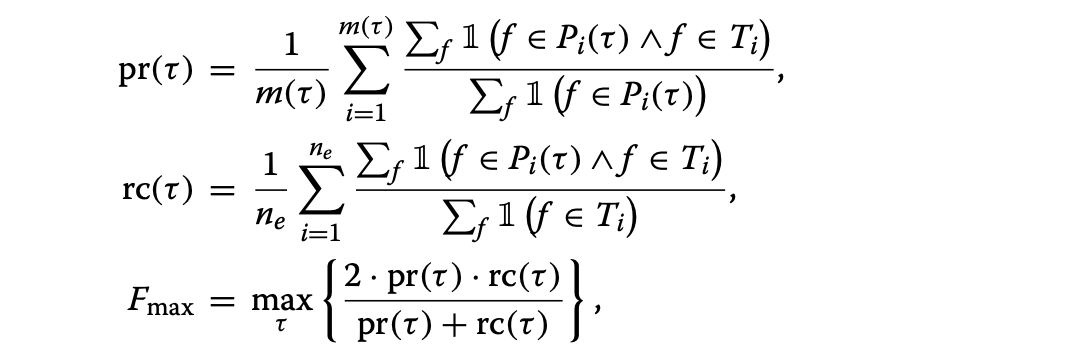

### Import Python Modules
First import the modules being used for this project:

In [62]:
import pandas as pd                               # Data manipulation and analysis library
import numpy as np                                # Numerical computing library
import re                                         # Regular expressions library for string manipulation
import time                                       # Time-related functions
import sys                                        # System-specific parameters and functions
np.set_printoptions(threshold=sys.maxsize)        # Set printing options for numpy arrays

# Plotting libraries
import matplotlib.pyplot as plt                   # Visualization library
import seaborn as sns                             # Statistical data visualization

# Multiprocessing and parallelism
import multiprocessing                            # Library for parallel processing
import sklearn                                    # Machine learning library
from datetime import datetime                     # Library for working with dates and times
import os                                         # Operating system interfaces
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'       # Set environment variable for Intel OpenMP

# Multiprocess 1
from data_preprocessing2 import process_batch     # Custom data preprocessing function
import concurrent.futures                         # Library for managing parallel execution

# SeqIO library from Biopyhton
from Bio import SeqIO                             # Biopython library for working with biological sequence data
import obonet                                     # Library for working with ontologies and OBO files

### Loading the data
To analyze the aminoacid sequences of the proteins, first I will parse the fasta file and print some of the records to see the data I'm dealing with as well as the lenght of the records list to see how many sequences are provided

In [63]:
#Parse the records from the fasta file into a list
filepath = '/Users/jd/Downloads/cafa-5-protein-function-prediction/Train/train_sequences.fasta'
records = list(SeqIO.parse(filepath,"fasta"))

#print the lenght of the list
print('Number of records: ', len(records), '\n')

#Print some of the records to look at the kind of data they contain
print(records[1].seq)
print('\n', records[1], '\n')
print(records[10])

Number of records:  142246 

MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKLLDGLVPDQQQLCKRNLELMHSIVRAARLTKSACTSSFSDMRWNWSSIESAPHFTPDLAKGTREAAFVVSLAAAVVSHAIARACASGDLPSCSCAAMPSEQAAPDFRWGGCGDNLRYYGLQMGSAFSDAPMRNRRSGPQDFRLMQLHNNAVGRQVLMDSLEMKCKCHGVSGSCSVKTCWKGLQDISTISADLKSKYLSATKVIPRQIGTRRQLVPREMEVRPVGENELVYLVSSPDYCTQNAKQGSLGTTDRQCNKTASGSESCGLMCCGRGYNAYTEVLVERCQCKYHWCCYVSCKTCKRTVERYVSK

 ID: O73864
Name: O73864
Description: O73864 sp|O73864|WNT11_DANRE Protein Wnt-11 OS=Danio rerio OX=7955 GN=wnt11 PE=2 SV=1
Number of features: 0
Seq('MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKLLDGLVPDQ...VSK') 

ID: Q96S79
Name: Q96S79
Description: Q96S79 sp|Q96S79|RSLAB_HUMAN Ras-like protein family member 10B OS=Homo sapiens OX=9606 GN=RASL10B PE=1 SV=1
Number of features: 0
Seq('MVSTYRVAVLGARGVGKSAIVRQFLYNEFSEVCVPTTARRLYLPAVVMNGHVHD...AIM')


### Data characteristics

train_sequences.fasta has 142,246 aminoacid sequece records, this is a good sign since there seems to be enough data for a deep learning model.

The features include:

- **ID:** alphanumerical value (object variable) for ID
- **Name:** alphanumerical value (object variable) as a name of the sequence
- **Sequence:** string variable with the exact order of the sequence of aminoacids for each record
- **Description:** 

As it is shown, the descriptions of each aminoacid sequence has the form "sp|P9WHI7|RECN_MYCT" which indicates that the protein with UniProt ID P9WHI7 and gene name RECN_MYCT was taken from Swiss-Prot (sp). Any sequences taken from TrEMBL will have tr in the header instead of sp. Swiss-Prot and TrEMBL are both parts of UniProtKB.

So the description will be separated into 'Databse' (sp or tr), 'OS', 'OX', 'GN', 'PE' and 'SV'
Then each record data is appended to a dictionary with key values 'ID', 'name', 'Databse', 'OS', 'OX', 'GN', 'PE', 'SV' 'Description' and 'Sequence'

In [64]:
#It is a rather substantial dataset, storing all extracted data in memory as lists can consume a 
#significant amount of memory so I'll perform multiprocessing by processing the records in batches
#thus optimizing memory consumption
batch_size = 1000
# Split the records into batches of 1000 samples each
batches = [records[i:i+batch_size] for i in range(0, len(records), batch_size)]

In [65]:
# Define the number of processes to use (number of CPU cores or a specific value)
num_processes = multiprocessing.cpu_count()  # Use the number of available CPU cores

# Define the function for data processing in each process
with multiprocessing.Pool(processes=num_processes) as pool:
    results = pool.starmap(process_batch, [(batch, start_idx, end_idx) for batch, start_idx, end_idx in zip(
                                            [records[i:i+batch_size] for i in range(0, len(records), batch_size)],
                                            range(0, len(records), batch_size),
                                            range(batch_size, len(records)+batch_size, batch_size))])
# Combine the results from all processes into a single dictionary
sequences_dict = {key: [] for key in results[0].keys()}
for result in results:
    for key, value in result.items():
        sequences_dict[key].extend(value)

# Create the DataFrame from the dictionary
sequences_df = pd.DataFrame(sequences_dict)

#Print the shape of the DataFrame (number of rows and columns)
print("DataFrame shape:", sequences_df.shape)
# Display the first few rows of the DataFrame
sequences_df.head()

DataFrame shape: (142246, 10)


,ID,Name,Database,OS,OX,GN,PE,SV,Description,Sequence
0,P20536,UNG_VACCC,sp,Vaccinia virus (strain Copenhagen),10249,UNG,1,1,Uracil-DNA glycosylase,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...
1,O73864,WNT11_DANRE,sp,Danio rerio,7955,wnt11,2,1,Protein Wnt-11,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...
2,O95231,VENTX_HUMAN,sp,Homo sapiens,9606,VENTX,1,1,Homeobox protein VENTX,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...
3,A0A0B4J1F4,ARRD4_MOUSE,sp,Mus musculus,10090,Arrdc4,1,1,Arrestin domain-containing protein 4,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...
4,P54366,GSC_DROME,sp,Drosophila melanogaster,7227,Gsc,2,2,Homeobox protein goosecoid,MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...


### Let's look at the data

Now let's print the shape of the Data frame to see the number of rows and columns, the data frame information to see if we have any missing data,the description to have a quick overview of the distribution of the data, and the top 20 most frequent descriptions

In [66]:
# Print information about the DataFrame, such as the data types of columns, non-null counts, and memory usage.
print('\n', sequences_df.info())
# Print summary statistics of the DataFrame
print(sequences_df.describe(), '\n')
# Print the top 20 most frequent values in the 'Description' column of the DataFrame, along with their counts.
print(sequences_df['Description'].value_counts().head(20))
print(sequences_df.shape)
print(sequences_df[[description.startswith('NF2L2') for description in sequences_df['Name']]])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142246 entries, 0 to 142245
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           142246 non-null  object
 1   Name         142246 non-null  object
 2   Database     142246 non-null  object
 3   OS           142243 non-null  object
 4   OX           138840 non-null  object
 5   GN           138840 non-null  object
 6   PE           142243 non-null  object
 7   SV           142243 non-null  object
 8   Description  142246 non-null  object
 9   Sequence     142246 non-null  object
dtypes: object(10)
memory usage: 10.9+ MB

 None
            ID       Name Database            OS      OX      GN      PE  \
count   142246     142246   142246        142243  138840  138840  142243   
unique  142246     142246        2          3156    2357   95083       5   
top     P20536  UNG_VACCC       sp  Homo sapiens    9606  Dscam1       1   
freq         1          1    838

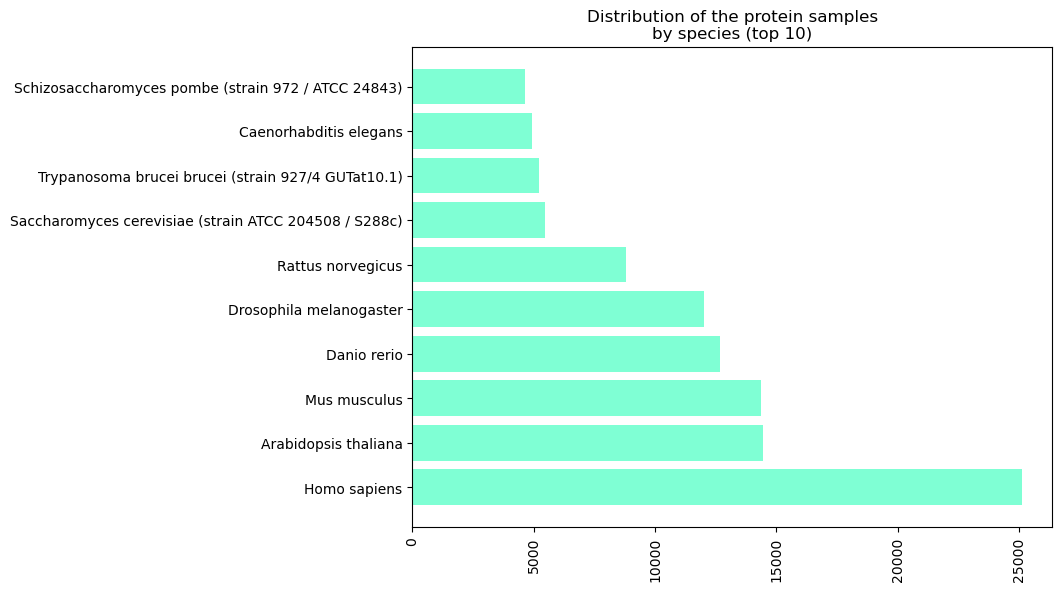

6


<Figure size 640x480 with 0 Axes>

In [67]:
#Prepare the data for a horizontal bar plot, setting the y_labels to the count of each protein description
# and the x_labels to the type of protein that corresponds to each number in the y_labels
y_labels = sequences_df.groupby(by = 'OS').count().sort_values('ID', ascending = False)['ID'].head(10)
x_labels = list(sequences_df.groupby(by = 'OS').count().sort_values('ID', ascending = False)['ID'].head(10).index.values)

#create an ax object, and plot the horizontal bars
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(x_labels, y_labels, color = 'aquamarine')

#set the title and rotate the x_ticks 90° so they don't overlap
plt.title('Distribution of the protein samples\nby species (top 10)')
plt.xticks(rotation = 'vertical')
plt.xlabel('')

#show the barplot
plt.show()
plt.clf()
print(sequences_df[sequences_df['ID']== 'P77596'].index[0])

In [68]:
# Define the path to the OBO file
obo_file_path = '/Users/jd/Downloads/cafa-5-protein-function-prediction/Train/go-basic.obo'

# Read the OBO file and create a graph
graph = obonet.read_obo(obo_file_path)

# Create a dictionary containing information for each node in the OBO file
obo_file_dict = {node_id: data for node_id, data in graph.nodes(data = True)}

# Create a DataFrame from the OBO file dictionary and transpose it
obo_df = pd.DataFrame(obo_file_dict)
obo_df = obo_df.transpose()

# Display the shape (number of rows and columns) of the OBO DataFrame
print(obo_df.shape)

# Display the first few rows of the OBO DataFrame
obo_df.head()

(43248, 10)


,name,namespace,def,synonym,is_a,alt_id,subset,xref,relationship,comment
GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]","[GO:0048308, GO:0048311]",NaN,NaN,NaN,NaN,NaN
GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,[GO:0007005],NaN,NaN,NaN,NaN,NaN
GO:0000003,reproduction,biological_process,"""The production of new individuals that contai...","[""reproductive physiological process"" EXACT []]",[GO:0008150],"[GO:0019952, GO:0050876]","[goslim_agr, goslim_chembl, goslim_flybase_rib...",[Wikipedia:Reproduction],NaN,NaN
GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",[GO:0005385],NaN,NaN,NaN,NaN,NaN
GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,[GO:0005385],NaN,NaN,NaN,NaN,NaN


In [69]:
# Read the 'train_terms.tsv' file into a Pandas DataFrame
train_terms = pd.read_table('train_terms.tsv')

# Display the normalized value counts of the 'aspect' column
# This shows the distribution of values in the 'aspect' column as percentages
print(train_terms.aspect.value_counts(normalize=True))

# Display the first few rows of the 'train_terms' DataFrame
print('\n', train_terms.head())

# Display the shape (number of rows and columns) of the 'train_terms' DataFrame
print(train_terms.shape)

# Read the 'train_taxonomy.tsv' file into a Pandas DataFrame
train_taxonomy = pd.read_table('train_taxonomy.tsv')

# Display the first few rows of the 'train_taxonomy' DataFrame
print('\n', train_taxonomy.head())

# Display the shape (number of rows and columns) of the 'train_taxonomy' DataFrame
print(train_taxonomy.shape, '\n')

aspect
BPO    0.652092
CCO    0.222977
MFO    0.124931
Name: proportion, dtype: float64

       EntryID        term aspect
0  A0A009IHW8  GO:0008152    BPO
1  A0A009IHW8  GO:0034655    BPO
2  A0A009IHW8  GO:0072523    BPO
3  A0A009IHW8  GO:0044270    BPO
4  A0A009IHW8  GO:0006753    BPO
(5363863, 3)

   EntryID  taxonomyID
0  Q8IXT2        9606
1  Q04418      559292
2  A8DYA3        7227
3  Q9UUI3      284812
4  Q57ZS4      185431
(142246, 2) 



In [70]:
#Parse the records from the fasta file into a list
filepath_tst = '/Users/jd/Downloads/cafa-5-protein-function-prediction/Test(Targets)/testsuperset.fasta'
test_set = list(SeqIO.parse(filepath_tst,"fasta"))

#print the lenght of the list
print('Number of records: ', len(test_set), '\n')

#Print some of the records to look at the kind of data they contain
print(test_set[106759])

Number of records:  141865 

ID: P01109
Name: P01109
Description: P01109	9031
Number of features: 0
Seq('MPLSASLPSKNYDYDYDSVQPYFYFEEEEENFYLAAQQRGSELQPPAPSEDIWK...SRA')


In [71]:
def normalize_sequences(sequences_df: pd.DataFrame, PERCENTILE: int, padding_value: float):
    # List of amino acids represented as a string
    amino_acids = 'ARNDCQEGHILKMFPSTWYVOXUZB'
    NUM_AMINO_ACIDS = len(amino_acids)

    # Convert each sequence in the 'sequences' dataframe to a list of individual amino acids and create a dictionary to map 
    # amino acids to their respective indices
    encoded_sequences = [list(sequence) for sequence in sequences_df['Sequence']]
    amino_acids_map = {aa: i for (i, aa) in list(enumerate(amino_acids))}

    # Calculate the 95th percentile of sequence lengths and truncate larger sequences
    PERCENTILE_95 = int(np.percentile(list(len(sequence) for sequence in encoded_sequences), PERCENTILE))
    print(f'95th percentile: {PERCENTILE_95}')
    truncated_sequences = [seq[:PERCENTILE_95] for seq in encoded_sequences]

    # Perform normalization and padding
    for sequence in truncated_sequences:
        SEQUENCE_LENGTH = len(sequence)
        for idx in range(PERCENTILE_95):
            if idx < SEQUENCE_LENGTH: 
                # Normalize each amino acid index by dividing it by the total number of amino acids
                sequence[idx] = amino_acids_map[sequence[idx]]/NUM_AMINO_ACIDS           
            else:
                # padding shorter sequences with the padding value 'NaN'
                sequence.append(padding_value)
    return PERCENTILE_95, np.array(truncated_sequences)
PERCENTILE = 95
padding_value = -1
PERCENTILE_95, padded_sequences = normalize_sequences(sequences_df, PERCENTILE, padding_value)

95th percentile: 1435


Index(['GO:0000001', 'GO:0000002', 'GO:0000003', 'GO:0000006', 'GO:0000007',
       'GO:0000009', 'GO:0000010', 'GO:0000011', 'GO:0000012', 'GO:0000014',
       ...
       'GO:2001308', 'GO:2001309', 'GO:2001310', 'GO:2001311', 'GO:2001312',
       'GO:2001313', 'GO:2001314', 'GO:2001315', 'GO:2001316', 'GO:2001317'],
      dtype='object', length=43248)

 aspect
BPO    0.652092
CCO    0.222977
MFO    0.124931
Name: proportion, dtype: float64


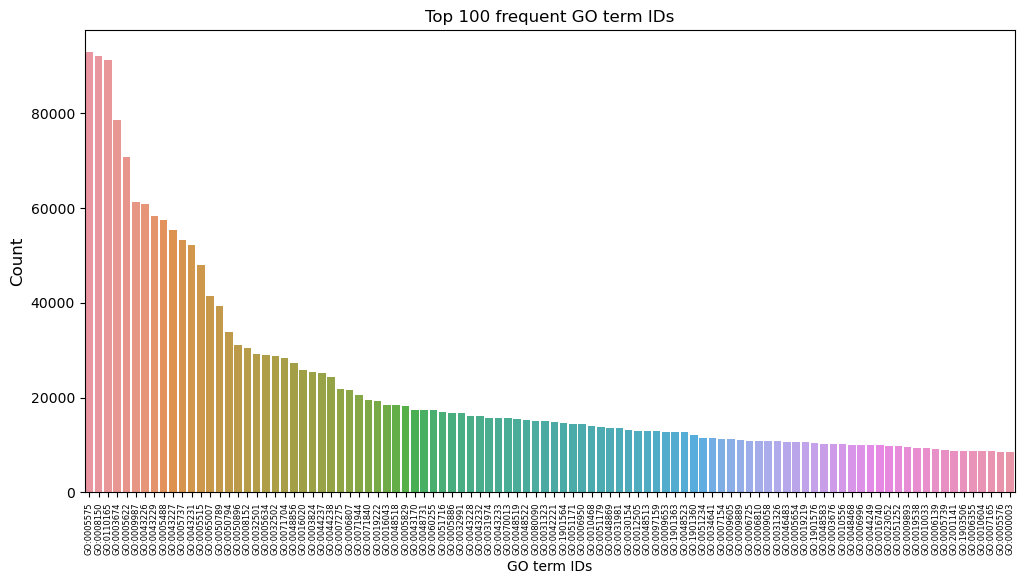


   EntryID  taxonomyID   term aspect
0  Q8IXT2        9606   2411    MFO
1  Q8IXT2        9606  41919    MFO
2  Q8IXT2        9606   2410    MFO
3  Q8IXT2        9606   3573    MFO
4  Q8IXT2        9606   2419    MFO
(5363863, 4)


<Figure size 640x480 with 0 Axes>

In [72]:
# Print the index (terms) of the obo_df DataFrame
print(obo_df.index)

# Create a dictionary (go_map) that maps terms to their corresponding indices
go_map = {aa: i for (i, aa) in list(enumerate(obo_df.index))}

# Create a reversed dictionary (go_map_reversed) to map indices back to terms
go_map_reversed = {i: aa for (i, aa) in list(enumerate(obo_df.index))}

# Merge 'train_taxonomy' and 'train_terms' DataFrames based on the 'EntryID' column
training_features = train_taxonomy.merge(train_terms, how='inner', on='EntryID')

# Display normalized value counts of the 'aspect' column in the merged DataFrame
print('\n', training_features.aspect.value_counts(normalize=True))

# Create a bar plot showing the top 100 frequent GO term IDs
plot_df = training_features['term'].value_counts().iloc[:100]
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize=10)
bp.set_ylabel("Count", fontsize=12)
plt.show()
plt.clf()

# Map GO terms to their corresponding indices using the go_map dictionary
training_features['term'] = [go_map[term] for term in training_features['term']]

# Display the first 5 rows of the modified training_features DataFrame
print('\n', training_features.head(5))

# Display the shape (number of rows and columns) of the modified training_features DataFrame
print(training_features.shape)

(4420737, 4)


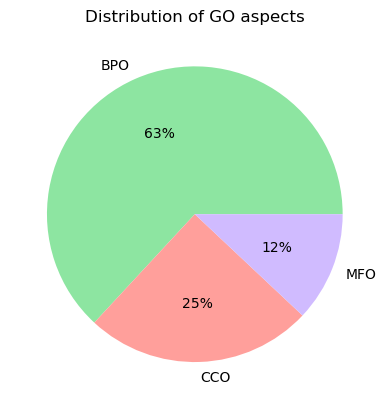

        EntryID  taxonomyID   term aspect
5038820  P9WFX1       83332  19728    BPO
5146940  O96935      186763   4309    BPO
4525326  Q0E959        7227  10739    BPO
1672841  P00560      559292   2409    MFO
2293460  Q9VAM5        7227  28010    BPO
(110518, 4)


<Figure size 640x480 with 0 Axes>

In [73]:
# Set the number of terms to select
NUMBER_OF_TERMS = 1500

# Get the most common terms (GO term IDs) and store them in the 'labels' list
labels = training_features['term'].value_counts().index[:NUMBER_OF_TERMS].tolist()

# Filter the 'training_features' DataFrame to include only rows with selected terms
training_features_updated = training_features.loc[training_features['term'].isin(labels)]

# Display the shape (number of rows and columns) of the filtered 'training_features_updated' DataFrame
print(training_features_updated.shape)

# Create a pie chart showing the distribution of GO aspects in the dataset
plt.pie(training_features_updated.aspect.value_counts(normalize = True), 
        colors = sns.color_palette('pastel')[2:6], labels = ['BPO', 'CCO', 'MFO'],
       autopct = '%.0f%%')
plt.title('Distribution of GO aspects', fontsize = 12)
plt.show()
plt.clf()

# Create subsamples for each aspect and concatenate them into a training sample
bpo_sample = training_features_updated[training_features_updated['aspect'] == 'BPO'].sample(n= int((training_features_updated.shape[0]*0.025)/3))
cco_sample = training_features_updated[training_features_updated['aspect'] == 'CCO'].sample(n= int((training_features_updated.shape[0]*0.025)/3))
mfo_sample = training_features_updated[training_features_updated['aspect'] == 'MFO'].sample(n= int((training_features_updated.shape[0]*0.025)/3))
training_sample = pd.concat([bpo_sample, cco_sample, mfo_sample]).sample(frac = 1)

# Display the first 5 rows of the 'training_sample' DataFrame
print(training_sample.head(5))
# Display the shape (number of rows and columns) of the 'training_sample' DataFrame
print(training_sample.shape)

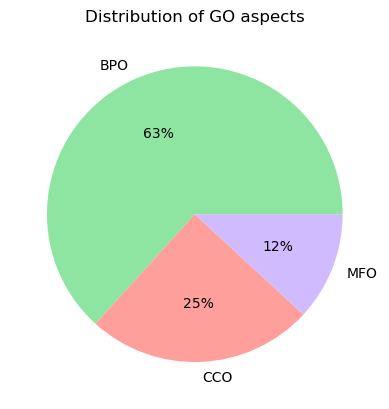

<Figure size 640x480 with 0 Axes>

In [74]:
plt.pie(training_sample.aspect.value_counts(normalize = True), 
        colors = sns.color_palette('pastel')[2:6], labels = ['BPO', 'CCO', 'MFO'],
       autopct = '%.0f%%')
plt.title('Distribution of GO aspects', fontsize = 12)
plt.show()
plt.clf()

term
3612     2374
5293     2308
34633    2276
2409     1961
3652     1812
6757     1506
18896    1505
18899    1458
18897    1419
3573     1414
Name: count, dtype: int64
[4570, 3667, 37270, 4507, 15827, 6420, 12798, 6669, 24734, 23223, 37068, 2410, 21400, 31797, 4806, 23215, 4665, 11884, 24699, 6458, 23540, 7686, 37071, 24692, 7209, 13381, 28024, 23219, 30755, 18903, 18898, 18086, 37261, 25138, 12795, 23222, 13375, 18902, 14309, 3839, 23218, 8678, 18849, 23411, 26177, 3795, 29717, 10444, 29806, 4567, 4896, 8662, 19729, 19728, 2455, 23528, 29594, 3658, 13865, 13864, 5294, 24428, 24335, 24331, 28010, 3586, 3724, 18901, 3573, 18897, 18899, 18896, 6757, 3652, 2409, 34633, 5293, 3612]


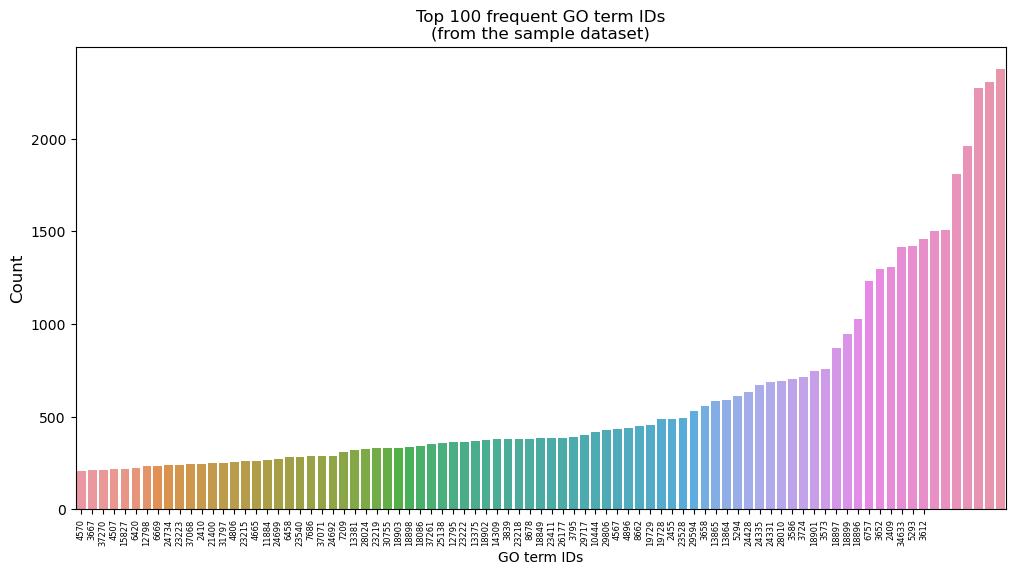

<Figure size 640x480 with 0 Axes>

In [75]:
# Select the first 100 values for plotting from the 'training_sample' DataFrame
plot_df = training_sample['term'].value_counts().iloc[:100]

# Print the value counts of the top 10 terms in the 'training_sample'
print(training_sample['term'].value_counts().iloc[:10])

# Create a figure and axis for the bar plot
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

# Prepare labels for the x-axis by reversing the first 78 terms
labels = list(plot_df.index[0:78])
labels.reverse()

# Create a bar plot (barplot) for the selected data
bp = sns.barplot(ax=axis, x=np.array(plot_df), y=plot_df.values)

# Set x-axis tick positions and labels
bp.set_xticks(range(0, 78), labels=labels, rotation=90, size=6)

# Set the title, x-axis label, and y-axis label for the plot
axis.set_title('Top 100 frequent GO term IDs\n(from the sample dataset)')
bp.set_xlabel("GO term IDs", fontsize=10)
bp.set_ylabel("Count", fontsize=12)

# Display the plot
plt.show()
plt.clf()

In [76]:
print(training_sample['aspect'].head())

5038820    BPO
5146940    BPO
4525326    BPO
1672841    MFO
2293460    BPO
Name: aspect, dtype: object


In [77]:
# Create an empty list to store the encoded aspects
encoded_aspects = []

# Dictionary for encoding aspects ('BPO', 'CCO', 'MFO') to numeric values
encoded_dict = {'BPO': 1, 'CCO':2, 'MFO':3}

# Counter to keep track of progress
appended = 0

# Loop through each aspect in the 'training_sample' DataFrame
for aspect in training_sample['aspect']:
    # Append the encoded value to the 'encoded_aspects' list
    encoded_aspects.append(encoded_dict[aspect])
    # Check the progress and print loading messages every 10%
    if appended == round(training_sample.shape[0]/10):
        print('loading...10%')
    if appended == round(training_sample.shape[0]/5):
        print('loading...20%')
    if appended == round(training_sample.shape[0]/3.33333):
        print('loading...30%')
    if appended == round(training_sample.shape[0]/2.5):
        print('loading...40%')
    if appended == round(training_sample.shape[0]/2):
        print('loading...50%')
    if appended == round(training_sample.shape[0]/1.66666):
        print('loading...60%')
    if appended == round(training_sample.shape[0]/1.42857):
        print('loading...70%')
    if appended == round(training_sample.shape[0]/1.25):
        print('loading...80%')
    if appended == round(training_sample.shape[0]/1.11111):
        print('loading...90%')
    if appended == (training_sample.shape[0]-1):
        print('loading...100%')
        
    appended +=1  # Increment the counter
    
# Update the 'aspect' column in the 'training_sample' DataFrame with encoded values    
training_sample['aspect'] = encoded_aspects

# Display the first few rows of the modified 'training_sample' DataFrame
print(training_sample.head())

loading...10%
loading...20%
loading...30%
loading...40%
loading...50%
loading...60%
loading...70%
loading...80%
loading...90%
loading...100%
        EntryID  taxonomyID   term  aspect
5038820  P9WFX1       83332  19728       1
5146940  O96935      186763   4309       1
4525326  Q0E959        7227  10739       1
1672841  P00560      559292   2409       3
2293460  Q9VAM5        7227  28010       1


In [78]:
training_sequences = []
appended = 0
encoded_id = []
c = 0
for id in training_sample['EntryID']:
    training_sequences.append(padded_sequences[sequences_df[sequences_df['ID']== id].index[0]])
    encoded_id.append(sequences_df[sequences_df['ID'] == id].index[0])
    if appended == round(training_sample.shape[0]/10):
        print('loading...10%')
    if appended == round(training_sample.shape[0]/5):
        print('loading...20%')
    if appended == round(training_sample.shape[0]/3.33333):
        print('loading...30%')
    if appended == round(training_sample.shape[0]/2.5):
        print('loading...40%')
    if appended == round(training_sample.shape[0]/2):
        print('loading...50%')
    if appended == round(training_sample.shape[0]/1.66666):
        print('loading...60%')
    if appended == round(training_sample.shape[0]/1.42857):
        print('loading...70%')
    if appended == round(training_sample.shape[0]/1.25):
        print('loading...80%')
    if appended == round(training_sample.shape[0]/1.11111):
        print('loading...90%')
    if appended == (training_sample.shape[0]-1):
        print('loading...100%')
    appended +=1
training_sample['EntryID'] = encoded_id
training_sample['sequence'] = training_sequences
print('\n', training_sample.head())

loading...10%
loading...20%
loading...30%
loading...40%
loading...50%
loading...60%
loading...70%
loading...80%
loading...90%
loading...100%

          EntryID  taxonomyID   term  aspect  \
5038820    39645       83332  19728       1   
5146940    59055      186763   4309       1   
4525326    43619        7227  10739       1   
1672841    75489      559292   2409       3   
2293460   120657        7227  28010       1   

                                                  sequence  
5038820  [0.48, 0.6, 0.24, 0.4, 0.6, 0.76, 0.0, 0.64, 0...  
5146940  [0.48, 0.44, 0.4, 0.64, 0.44, 0.28, 0.16, 0.0,...  
4525326  [0.48, 0.4, 0.2, 0.28, 0.48, 0.4, 0.2, 0.04, 0...  
1672841  [0.48, 0.6, 0.4, 0.6, 0.6, 0.44, 0.4, 0.6, 0.7...  
2293460  [0.48, 0.6, 0.0, 0.28, 0.76, 0.2, 0.24, 0.04, ...  


In [79]:
go_map_reversed[10311]

'GO:0019058'

In [80]:
from sklearn.preprocessing import MultiLabelBinarizer
grouped_terms_sample = training_sample.groupby('EntryID').agg({
    'taxonomyID': 'first',
    'term': lambda x: x.tolist(),  # Aggregate GO terms into lists
    'aspect': 'first',
    'sequence': 'first'}).reset_index()
print(grouped_terms_sample.head())

mlb = MultiLabelBinarizer()
multi_label_terms = mlb.fit_transform(grouped_terms_sample['term'])

y = pd.DataFrame(multi_label_terms, columns = [go_map_reversed[term] for term in training_sample['term'].sort_values().unique()])
#encoded_sample = pd.concat([training_sample.drop('term', axis =1), multi_label_terms_df], axis = 1)
y.head()

   EntryID  taxonomyID            term  aspect  \
0        0       10249         [19740]       1   
1        1        7955         [10442]       1   
2        2        9606           [644]       3   
3        3       10090  [17236, 26023]       1   
4        4        7227          [3573]       3   

                                            sequence  
0  [0.48, 0.08, 0.6, 0.76, 0.64, 0.76, 0.6, 0.32,...  
1  [0.48, 0.64, 0.24, 0.72, 0.04, 0.08, 0.52, 0.4...  
2  [0.48, 0.04, 0.4, 0.6, 0.6, 0.6, 0.56, 0.56, 0...  
3  [0.48, 0.28, 0.28, 0.24, 0.0, 0.28, 0.0, 0.12,...  
4  [0.48, 0.76, 0.24, 0.64, 0.08, 0.6, 0.56, 0.56...  


,GO:0000003,GO:0000041,GO:0000070,GO:0000122,GO:0000139,GO:0000151,GO:0000166,GO:0000226,GO:0000228,GO:0000271,...,GO:2000112,GO:2000113,GO:2000145,GO:2000146,GO:2000147,GO:2000241,GO:2000243,GO:2001020,GO:2001141,GO:2001233
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
from sklearn.decomposition import PCA
sequences_pc_df = pd.DataFrame(columns =['PC' + str(i) for i in range(PERCENTILE_95)])
PRINCIPAL_COMPONENTS = 50
appended = 0
c = 0
for i in range(grouped_terms_sample.shape[0]):
    pca_sample = {'PC' + str(component): grouped_terms_sample['sequence'].iloc[i][component] 
                  for component in range(len(grouped_terms_sample['sequence'].iloc[i]))}
    
    sequences_pc_df = pd.concat([sequences_pc_df, pd.DataFrame([pca_sample])], ignore_index=True)
    
    if appended == round(training_sample.shape[0]/(100 - c)):
        print('loading...' + str(c+1) + '%')
        c +=1
    appended +=1
    
print('loading...' + str(c+1) + '%')

# Perform PCA on pca_sample_df
pca = PCA(n_components=PRINCIPAL_COMPONENTS)
sequences_pc = pca.fit_transform(sequences_pc_df)
    
# Convert the PCA results to a DataFrame
PC_sequences = pd.DataFrame(sequences_pc, columns=['PC' + str(i+1) for i in range(PRINCIPAL_COMPONENTS)])
X = pd.concat([grouped_terms_sample.drop(columns = ['term', 'sequence']), PC_sequences], axis = 1).values

loading...1%
loading...2%
loading...3%
loading...4%
loading...5%
loading...6%
loading...7%
loading...8%
loading...9%
loading...10%
loading...11%
loading...12%
loading...13%
loading...14%
loading...15%
loading...16%
loading...17%
loading...18%
loading...19%
loading...20%
loading...21%
loading...22%
loading...23%
loading...24%
loading...25%
loading...26%
loading...27%
loading...28%
loading...29%
loading...30%
loading...31%
loading...32%
loading...33%
loading...34%
loading...35%
loading...36%
loading...37%
loading...38%
loading...39%
loading...40%
loading...41%
loading...42%
loading...43%
loading...44%
loading...45%
loading...46%
loading...47%
loading...48%
loading...49%
loading...50%
loading...51%
loading...52%
loading...53%
loading...54%
loading...55%
loading...56%
loading...57%
loading...58%
loading...59%
loading...60%
loading...61%
loading...62%
loading...63%
loading...64%
loading...65%
loading...66%
loading...67%
loading...68%
loading...69%
loading...70%
loading...71%
loading...72%
l

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [83]:
# Define the path to the information accretion file
information_accretion_path = '/Users/jd/Downloads/cafa-5-protein-function-prediction/IA.txt'

# Open and read the content of the information accretion file
with open(information_accretion_path, 'r') as file:
    lines = file.readlines()

# Print the number of lines read from the file
print(len(lines))

# Create a dictionary to store information accretion data
information_accretion = {'term': range(len(lines)), 'IA': []}

# Parse each line in the file and populate the 'IA' list in the dictionary
for line in lines:
    information_accretion['IA'].append(line.split()[1])

# Create a Pandas DataFrame from the information accretion dictionary
information_accretion = pd.DataFrame(information_accretion)

# Display the first 5 rows of the information accretion DataFrame
information_accretion.head()

43248


,term,IA
0,0,0.0
1,1,3.10383581098454
2,2,3.4394041159928754
3,3,0.056583528366367424
4,4,6.400377192572712


In [85]:
# Import necessary libraries
from sklearn.metrics import f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define input shape, batch size, and number of labels
INPUT_SHAPE = [X_train.shape[1]]
BATCH_SIZE = 5120 * 2
NUM_OF_LABELS = y_train.shape[1]

# Define the architecture of the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(0.009)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=l2(0.009)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1024, activation='relu', kernel_regularizer=l2(0.009)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units= NUM_OF_LABELS, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss= 'binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
go_prediction = model.fit(
    X_train, y_train,
    batch_size = BATCH_SIZE,
    epochs=6, validation_split = 0.3,
    callbacks = [early_stopping]
)

Epoch 1/6


2023-08-16 12:09:40.304800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 11.7266 - binary_accuracy: 0.5025 - auc_3: 0.4997

2023-08-16 12:09:44.611670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 6s 1s/step - loss: 11.7266 - binary_accuracy: 0.5025 - auc_3: 0.4997 - val_loss: 10.4308 - val_binary_accuracy: 0.5267 - val_auc_3: 0.5067
Epoch 2/6
4/4 [==============================] - 4s 1s/step - loss: 9.8977 - binary_accuracy: 0.5264 - auc_3: 0.5043 - val_loss: 8.7475 - val_binary_accuracy: 0.6740 - val_auc_3: 0.5140
Epoch 3/6
4/4 [==============================] - 6s 2s/step - loss: 8.2914 - binary_accuracy: 0.6163 - auc_3: 0.5093 - val_loss: 7.2815 - val_binary_accuracy: 0.9182 - val_auc_3: 0.5233
Epoch 4/6
4/4 [==============================] - 7s 2s/step - loss: 6.8858 - binary_accuracy: 0.8043 - auc_3: 0.5123 - val_loss: 5.9999 - val_binary_accuracy: 0.9938 - val_auc_3: 0.5265
Epoch 5/6
4/4 [==============================] - 7s 2s/step - loss: 5.6550 - binary_accuracy: 0.9633 - auc_3: 0.5130 - val_loss: 4.8707 - val_binary_accuracy: 0.9982 - val_auc_3: 0.5239
Epoch 6/6
4/4 [==============================] - 6s 2s/step - loss: 4.5691 - b

<Axes: title={'center': 'Accuracy'}>

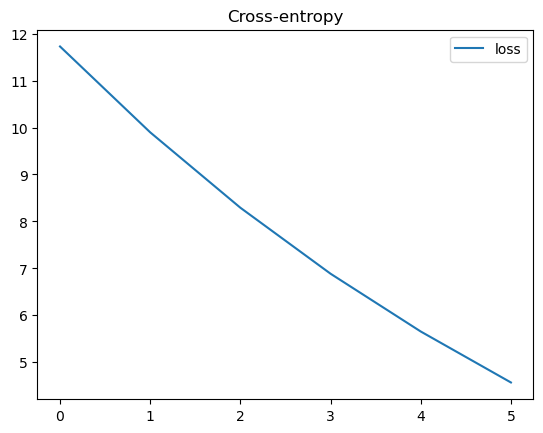

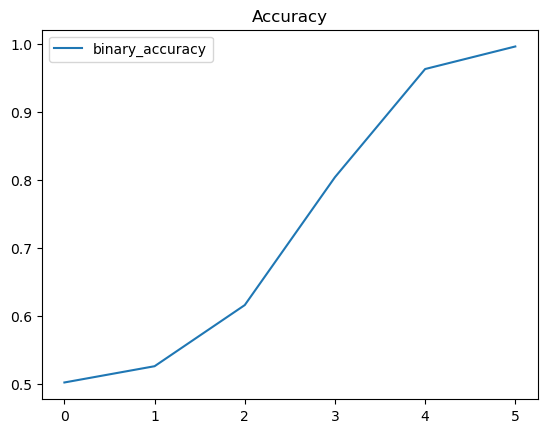

In [86]:
# Create a Pandas DataFrame from the training history of 'go_prediction'
go_prediction_df = pd.DataFrame(go_prediction.history)

# Plot the training loss using the 'loss' column from the DataFrame
go_prediction_df.loc[:, ['loss']].plot(title="Cross-entropy")

# Plot the binary accuracy using the 'binary_accuracy' column from the DataFrame
go_prediction_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

In [87]:
# Predict labels for the test data using the trained model
y_pred = model.predict(X_test)

 53/392 [===>..........................] - ETA: 0s

2023-08-16 12:10:15.244455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


392/392 [==============================] - 1s 2ms/step


In [88]:
ia_weights = {}  # Dictionary to store GO term weights

# Open and read the information accretion file to populate the weights dictionary
with open(information_accretion_path, "r") as ia_file:
    for line in ia_file:
         # Split each line into GO term and weight, and store in the dictionary
        go_term, weight = line.strip().split("\t")
        ia_weights[go_term] = float(weight)

In [89]:
# Create a DataFrame from the predicted labels (y_pred)
y_pred_df = pd.DataFrame(y_pred, columns = y.columns)

    GO:0000003  GO:0000041  GO:0000070  GO:0000122  GO:0000139  GO:0000151  \
0     0.229838    0.230558    0.221879    0.231326    0.227327    0.233380   
1     0.312562    0.324274    0.293578    0.309930    0.308726    0.319118   
2     0.534464    0.565257    0.579701    0.516759    0.512184    0.561901   
3     0.213731    0.210426    0.192606    0.198206    0.203009    0.192609   
4     0.333084    0.337376    0.312327    0.318034    0.317934    0.329069   
5     0.265297    0.251406    0.249288    0.261322    0.264860    0.262920   
6     0.252553    0.248606    0.228696    0.238080    0.235122    0.231316   
7     0.297780    0.280963    0.278439    0.303295    0.299857    0.298053   
8     0.263463    0.269562    0.252154    0.268252    0.283666    0.273515   
9     0.214246    0.212529    0.201046    0.206861    0.219464    0.211900   
10    0.228245    0.223820    0.217217    0.230054    0.235394    0.224041   
11    0.267057    0.262695    0.237180    0.247717    0.246079  

In [111]:
# Initialize variables to store weighted counts
wTP_total = 0
wFP_total = 0
wFN_total = 0

threshold = 0.27

# Iterate through columns of y_pred DataFrame
for column in y.columns:
    weight = ia_weights.get(column, 0.0)  # Get weight from ia_weights dictionary
    
    # Compute weighted true positives, false positives, and false negatives
    wTP = sum((y_test[column] == 1) & (y_pred_df[column] >= threshold).astype(int)) * weight
    wFP = sum((y_test[column] == 0) & (y_pred_df[column] >= threshold).astype(int)) * weight
    wFN = sum((y_test[column] == 1) & (y_pred_df[column] < threshold).astype(int)) * weight
    
    # Accumulate weighted counts
    wTP_total += wTP
    wFP_total += wFP
    wFN_total += wFN
        
# Compute weighted precision and recall
weighted_precision = wTP_total / (wTP_total + wFP_total)
weighted_recall = wTP_total / (wTP_total + wFN_total)

print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)

Weighted Precision: 0.0009282865925876572
Weighted Recall: 0.31746630269793646


In [110]:
# Calculate the weighted F1 score using the formula
weighted_f1 = (2 * weighted_precision * weighted_recall)/ (weighted_precision + weighted_recall)

# Print the calculated weighted F1 score
print(f'weighted F1 score: {weighted_f1}')

weighted F1 score: 0.001840175654644586


In [93]:
y_pred_df.head(10)

,GO:0000003,GO:0000041,GO:0000070,GO:0000122,GO:0000139,GO:0000151,GO:0000166,GO:0000226,GO:0000228,GO:0000271,...,GO:2000112,GO:2000113,GO:2000145,GO:2000146,GO:2000147,GO:2000241,GO:2000243,GO:2001020,GO:2001141,GO:2001233
0,0.229838,0.230558,0.221879,0.231326,0.227327,0.233380,0.229592,0.228409,0.225199,0.217361,...,0.227781,0.220542,0.226294,0.225000,0.219653,0.226512,0.204820,0.214419,0.220844,0.221163
1,0.312562,0.324274,0.293578,0.309930,0.308726,0.319118,0.302124,0.314559,0.304279,0.323261,...,0.300240,0.317986,0.308620,0.302074,0.300938,0.314025,0.298958,0.306165,0.299649,0.308246
2,0.534464,0.565257,0.579701,0.516759,0.512184,0.561901,0.510857,0.524350,0.478416,0.592004,...,0.503501,0.533123,0.530205,0.588295,0.548888,0.586043,0.521249,0.549166,0.494420,0.565575
3,0.213731,0.210426,0.192606,0.198206,0.203009,0.192609,0.206537,0.196137,0.194238,0.205307,...,0.193963,0.209399,0.210543,0.204972,0.190686,0.187519,0.196795,0.194119,0.188205,0.191495
4,0.333084,0.337376,0.312327,0.318034,0.317934,0.329069,0.303965,0.318441,0.316685,0.340510,...,0.310550,0.331275,0.330077,0.326504,0.324019,0.330689,0.313371,0.326260,0.312259,0.320279
5,0.265297,0.251406,0.249288,0.261322,0.264860,0.262920,0.258130,0.258409,0.261447,0.260124,...,0.262568,0.266546,0.262569,0.253176,0.251255,0.248467,0.263780,0.246356,0.239199,0.246761
6,0.252553,0.248606,0.228696,0.238080,0.235122,0.231316,0.252882,0.238634,0.239360,0.238064,...,0.235034,0.241586,0.253903,0.241369,0.230409,0.236542,0.234014,0.232632,0.225428,0.231822
7,0.297780,0.280963,0.278439,0.303295,0.299857,0.298053,0.290419,0.289440,0.297184,0.295443,...,0.298553,0.300257,0.299738,0.287522,0.293566,0.284549,0.299116,0.282413,0.280558,0.283911
8,0.263463,0.269562,0.252154,0.268252,0.283666,0.273515,0.265193,0.258079,0.263474,0.269929,...,0.264683,0.278027,0.274644,0.249403,0.252051,0.258399,0.272289,0.262953,0.263784,0.256775
9,0.214246,0.212529,0.201046,0.206861,0.219464,0.211900,0.206258,0.212299,0.207296,0.206007,...,0.209403,0.210983,0.210684,0.199905,0.195071,0.197334,0.207771,0.198466,0.199668,0.202301
